<div class="usecase-title">Ease of Travel for Young Adults</div>
<div class="usecase-authors"><b>Authored by: </b> Vivek Olladapu</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, matpotlib, numpy, folium</div>
</div>

<div class="usecase-section-header">Scenario</div>


Young adults (aged 18–21) in Melbourne rely heavily on public transport and active modes (walking, cycling) to get to work, study, and social activities. Understanding which suburbs offer the best accessibility to bus stops, tram stops, and bike-share docks and where gaps in coverage exist-can inform student housing choices, campus planning, and local council investment.

In this use case, you will pull live infrastructure data from Melbourne’s Open Data portal, clean and standardise the coordinate data, compute simple accessibility metrics (e.g., distance to the nearest stop), and cluster stops to identify high-density service areas. Finally, you will visualise these patterns on interactive maps and static trend plots to highlight transit-rich neighbourhoods and underserved zones.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:

- Fetch multi-modal transport data (bus stops, tram stops, bike-share docks) using Melbourne’s Open Data APIs.

- Clean and standardise raw geospatial tables in pandas: remove duplicates, drop missing points, and split text-based coordinates into numeric lat/lon.

- Compute accessibility metrics, such as geodesic distance to the nearest stop for any given location.

- Cluster transport stops to reveal high-density service areas using simple radius-based or scikit-learn clustering.

- Build interactive maps in Folium with MarkerCluster and HeatMap layers to explore spatial coverage.

- Create static plots in Matplotlib/Seaborn to compare stop densities across suburbs.

- Identify transit deserts-areas underserved by public transport and recommend neighbourhoods for service improvements.

- Combine multiple layers (bus, tram, bike) into a cohesive, multi-modal accessibility dashboard.

# Importing Required Libraries

In [206]:
# Core libraries
import pandas as pd
import numpy as np
import requests

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator, FixedFormatter

# Mapping
import folium
from folium import Map, Marker, FeatureGroup, LayerControl
from folium.plugins import MarkerCluster, HeatMap

# Geospatial
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from sklearn.neighbors import BallTree


# Importing Datasets

Reading first data set through API for the bus_stops

In [210]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'bus-stops'
# Build the full export URL for CSV format
url = f'{base_url}{dataset_id}/exports/csv'
# Define parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    bus_stops = pd.read_csv(StringIO(url_content), delimiter=';')
    # Print first 10 rows
    print(bus_stops.head(10))
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')

                              geo_point_2d  \
0   -37.80000725498236, 144.96097934573706   
1  -37.807815885141665, 144.91663837870203   
2   -37.82500188553457, 144.95694945167727   
3   -37.79859348300079, 144.94845845599968   
4  -37.800561849475905, 144.96449089849344   
5   -37.82168352630472, 144.96129766991564   
6     -37.8338230491092, 144.9795143710974   
7  -37.794769078965565, 144.92642079506638   
8   -37.803343440196116, 144.9693670992385   
9   -37.81570404359276, 144.96116717702685   

                                           geo_shape  prop_id  addresspt1  \
0  {"coordinates": [144.96097934573706, -37.80000...        0   39.387723   
1  {"coordinates": [144.91663837870203, -37.80781...        0   80.959563   
2  {"coordinates": [144.95694945167727, -37.82500...        0   85.169791   
3  {"coordinates": [144.94845845599968, -37.79859...        0   42.168240   
4  {"coordinates": [144.96449089849344, -37.80056...        0   32.129118   
5  {"coordinates": [144.9612976

The result shows the first ten records from Melbourne’s “bus-stops” dataset. Each row includes a geo_point_2d string (the stop’s latitude and longitude) alongside a geo_shape JSON object with the same co-ordinates. The various ID columns (prop_id, objectid, mcc_id, etc.) link this signage asset to address and council databases, while asset_class and asset_type describe it as “Signage - Public Transport.” Descriptive fields like model_desc and model_no tell you the exact sign-panel type, and roadseg_id identifies the street segment where the sign is located.

Reading first data set through API for the tram_stops

In [214]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'city-circle-tram-stops'
# Build the full export URL for CSV format
url = f'{base_url}{dataset_id}/exports/csv'
# Define parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    tram_stops = pd.read_csv(StringIO(url_content), delimiter=';')
    # Print first 10 rows
    print(tram_stops.head(10))
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')

                              geo_point_2d  \
0   -37.81667338583987, 144.97015587085124   
1  -37.813414856197724, 144.94137823870162   
2  -37.814591782869805, 144.94655055842398   
3   -37.81538859129167, 144.97453393804187   
4   -37.82023778673241, 144.95786314283018   
5  -37.808876998255194, 144.96634474519394   
6   -37.81358116790275, 144.97406360491075   
7    -37.8176316450406, 144.96690455927876   
8   -37.81865571347738, 144.94650837136655   
9   -37.80956201428191, 144.97291405751537   

                                           geo_shape  \
0  {"coordinates": [144.97015587085124, -37.81667...   
1  {"coordinates": [144.94137823870162, -37.81341...   
2  {"coordinates": [144.94655055842398, -37.81459...   
3  {"coordinates": [144.97453393804187, -37.81538...   
4  {"coordinates": [144.95786314283018, -37.82023...   
5  {"coordinates": [144.96634474519394, -37.80887...   
6  {"coordinates": [144.97406360491075, -37.81358...   
7  {"coordinates": [144.96690455927876, -37.8

The result shows the first ten records from Melbourne’s “city‐circle‐tram‐stops” dataset. Each row begins with geo_point_2d, a text string of the stop’s co-ordinates (latitude, longitude), and geo_shape, a GeoJSON object containing the same point. The name column gives the tram stop’s location, while xorg lists the owning organisation (“GIS Team”). The stop_no field is the stop’s numeric code and xsource indicates the data source (Mapbase). The xdate column records when the data was captured (18 October 2011), and mccid_str/mccid_int are Melbourne City Council identifiers. This mix of spatial co-ordinates and metadata lets you accurately map each tram stop and link it to council records.

Reading first data set through API for the bike_docks

In [218]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'bike-share-dock-locations'
# Build the full export URL for CSV format
url = f'{base_url}{dataset_id}/exports/csv'
# Define parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    bike_docks = pd.read_csv(StringIO(url_content), delimiter=';')
    # Print first 10 rows
    print(bike_docks.head(10))
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')

   station_id                                               name  \
0          12              Fitzroy Town Hall - Moor St - Fitzroy   
1          17  Yarra's Point - Lorimer St / Yarra River - Doc...   
2          29         Southern Cross Station - Spencer St - City   
3          36                 Napier St / Victoria Pde - Fitzroy   
4          41  Domain Interchange - Park St / St Kilda Rd - M...   
5          34          RACV - Bourke St / New Chancery Ln - City   
6          21            Bridport St / Montague St - Albert Park   
7          22            Pickles St / Ingles St - Port Melbourne   
8          26                          Beach St - Port Melbourne   
9          40      Rod Laver Arena - Batman Ave / Swan St - City   

    rental_method  capacity        lat         lon                location  
0  CREDITCARD,KEY        11 -37.801813  144.979209  -37.801813, 144.979209  
1  CREDITCARD,KEY        15 -37.823805  144.943051  -37.823805, 144.943051  
2  CREDITCARD,KEY   

The result shows the first ten records from Melbourne’s bike-share dock dataset. Each row begins with a station_id (the unique dock identifier) and name (its street intersection or nearby landmark). The rental_method column tells you how users access the bikes (e.g. CREDITCARD, KEY), while capacity is the total number of docks available. The lat and lon fields are the numeric co-ordinates, and the original location string repeats those values. Altogether, this table gives you both the spatial co-ordinates and key metadata needed to map and analyse bike-share accessibility across the city.

In [221]:
# CKAN API base URL
base_url = 'https://discover.data.vic.gov.au/api/3/action/datastore_search'

# Resource ID for the dataset
resource_id = '23f1f850-efd7-45c8-9442-78051b408031'

# API parameters
params = {
    "resource_id": resource_id,
    "limit": 1000   # CKAN default is 100, you can adjust or paginate
}

# Send the request
response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    if data.get("success"):
        records = data["result"]["records"]
        train_stops = pd.DataFrame.from_records(records)
        print("Shape:", train_stops.shape)
        print(train_stops.head(10))   # show first 10 rows
    else:
        print("API request succeeded but returned no data.")
else:
    print(f"Request failed with status code {response.status_code}")

Shape: (219, 7)
   _id                             geo_point_2d  \
0    1           -37.77839599999999, 145.031251   
1    2           -37.86724899999996, 144.830604   
2    3  -37.761897999999974, 144.96056099999998   
3    4           -37.82241099999999, 145.045617   
4    5   -37.73345899999998, 144.96274700000004   
5    6           -38.050928, 145.36604499999999   
6    7           -37.74556799999999, 145.000181   
7    8   -38.03968099999997, 145.34497299999998   
8    9             -37.81927399999995, 145.1218   
9   10  -37.851350999999966, 145.08036800000002   

                                           geo_shape he_loop lift        pids  \
0  {"coordinates": [145.031251, -37.7783959999999...      No   No  Dot Matrix   
1  {"coordinates": [144.830604, -37.8672489999999...      No   No         LCD   
2  {"coordinates": [144.96056099999998, -37.76189...      No   No          No   
3  {"coordinates": [145.045617, -37.8224109999999...      No   No          No   
4  {"coordinates"

The first ten records from Melbourne’s train station dataset list each station’s name and ID alongside its latitude and longitude. The geo_shape field repeats the co-ordinates for mapping, while he_loop and lift show accessibility features such as hearing loops and lifts. The pids column notes the type of passenger information display system (e.g. LCD, CRT, Dot Matrix). Together, these details give both the location and key accessibility attributes of Melbourne’s train stations.

# Data Preprocessing and Exploratory Data Analysis

In [225]:
# 1. Drop duplicates & any rows without a coordinate
bus_stops_clean = (
    bus_stops
    .drop_duplicates()
    .dropna(subset=['geo_point_2d'])
    .copy()
)

# 2. Split the "lat,lon" text into numeric columns
bus_stops_clean[['lat','lon']] = (
    bus_stops_clean['geo_point_2d']
      .str.split(',', expand=True)
      .astype(float)
)

# 3. Drop the original coordinate columns
bus_stops_clean = bus_stops_clean.drop(
    columns=['geo_point_2d', 'geo_shape'],
    errors='ignore'
)

# 4. Reset the index
bus_stops_clean = bus_stops_clean.reset_index(drop=True)

# Quick sanity check
print("Bus stops cleaned:", bus_stops_clean.shape)
bus_stops_clean.head()

# 1. Drop duplicates & any rows without a coordinate
train_stops_clean = (
    train_stops
    .drop_duplicates()
    .dropna(subset=['geo_point_2d'])
    .copy()
)

# 2. Split the "lat,lon" text into numeric columns
train_stops_clean[['lat','lon']] = (
    train_stops_clean['geo_point_2d']
      .str.split(',', expand=True)
      .astype(float)
)

# 3. Drop the original coordinate columns
train_stops_clean = train_stops_clean.drop(
    columns=['geo_point_2d', 'geo_shape'],
    errors='ignore'
)

# 4. Reset the index
train_stops_clean = train_stops_clean.reset_index(drop=True)

# Quick sanity check
print("Train stops cleaned:", train_stops_clean.shape)
train_stops_clean.head()


Bus stops cleaned: (309, 16)
Train stops cleaned: (219, 7)


,_id,he_loop,lift,pids,station,lat,lon
0,1,No,No,Dot Matrix,Alphington,-37.778396,145.031251
1,2,No,No,LCD,Altona,-37.867249,144.830604
2,3,No,No,No,Anstey,-37.761898,144.960561
3,4,No,No,No,Auburn,-37.822411,145.045617
4,5,No,No,No,Batman,-37.733459,144.962747


The cleaned bus_stops_clean table contains 309 unique signage records, each retaining its key metadata (e.g. prop_id, asset_type, model_desc, etc.) alongside two precise numeric columns, lat and lon. All duplicate rows and any entries without valid geo_point_2d co-ordinates have been removed, and the original geo_point_2d/geo_shape fields dropped. The index has been reset to a zero-based sequence, yielding a tidy DataFrame of bus-stop locations ready for mapping or further spatial analysis.

In [230]:
tram_stops_clean = (
    tram_stops
    .drop_duplicates()
    .dropna(subset=['geo_point_2d'])
    .copy()
)
tram_stops_clean[['lat','lon']] = (
    tram_stops_clean['geo_point_2d']
      .str.split(',', expand=True)
      .astype(float)
)
tram_stops_clean = tram_stops_clean.drop(columns=['geo_point_2d','geo_shape'], errors='ignore')
tram_stops_clean = tram_stops_clean.reset_index(drop=True)

print("Tram stops cleaned:", tram_stops_clean.shape)
tram_stops_clean.head()


Tram stops cleaned: (28, 9)


,name,xorg,stop_no,mccid_str,xsource,xdate,mccid_int,lat,lon
0,Russell Street / Flinders Street,GIS Team,6,NaN,Mapbase,2011-10-18,28,-37.816673,144.970156
1,New Quay Promenade / Docklands Drive,GIS Team,D10,NaN,Mapbase,2011-10-18,11,-37.813415,144.941378
2,Etihad Statium / La Trobe Street,GIS Team,D1,NaN,Mapbase,2011-10-18,13,-37.814592,144.946551
3,Spring Street / Flinders Street,GIS Team,8,NaN,Mapbase,2011-10-18,26,-37.815389,144.974534
4,Melbourne Aquarium / Flinders Street,GIS Team,2,NaN,Mapbase,2011-10-18,4,-37.820238,144.957863


The cleaned tram_stops_clean table comprises 28 unique City-Circle tram-stop records, each with essential fields (name, xorg, stop_no, xdate, etc.) plus the newly created lat and lon floats. Any duplicates or rows missing the original geo_point_2d co-ordinates have been discarded, and the geo_point_2d/geo_shape columns removed. The index has been reset so you have a neat, zero-based list of tram stops prepared for visualisation or distance-based computations.

In [233]:
bike_docks_clean = (
    bike_docks
    .drop_duplicates()
    .assign(
        lat=lambda df: pd.to_numeric(df['lat'], errors='coerce'),
        lon=lambda df: pd.to_numeric(df['lon'], errors='coerce')
    )
    .dropna(subset=['lat','lon'])         # drop any that still failed to parse
    .drop(columns=['location'], errors='ignore')  # remove raw text coord column
    .reset_index(drop=True)
)

print("Bike docks cleaned:", bike_docks_clean.shape)
bike_docks_clean.head()


Bike docks cleaned: (50, 6)


,station_id,name,rental_method,capacity,lat,lon
0,12,Fitzroy Town Hall - Moor St - Fitzroy,"CREDITCARD,KEY",11,-37.801813,144.979209
1,17,Yarra's Point - Lorimer St / Yarra River - Doc...,"CREDITCARD,KEY",15,-37.823805,144.943051
2,29,Southern Cross Station - Spencer St - City,"CREDITCARD,KEY",27,-37.818124,144.953581
3,36,Napier St / Victoria Pde - Fitzroy,"CREDITCARD,KEY",11,-37.808266,144.979005
4,41,Domain Interchange - Park St / St Kilda Rd - M...,"CREDITCARD,KEY",15,-37.832396,144.971678


The cleaned bike_docks_clean table contains 50 unique stations, each with only the key metadata (station_id, name, rental_method, capacity) and two precise numeric columns (lat and lon). All duplicates and any rows lacking valid coordinates have been removed, and the original text-based location column has been dropped. The index has been reset to a zero-based sequence, resulting in a tidy DataFrame of dock locations ready for mapping or spatial analysis.

## HeatMap to explore spatial coverage

In [237]:
# Base map
melbourne_map = Map(location=[-37.8136, 144.9631], zoom_start=13)

# Bus stops
bus_layer = FeatureGroup(name="Bus Stops")
for lat, lon in zip(bus_stops_clean['lat'], bus_stops_clean['lon']):
    Marker([lat, lon], icon=folium.Icon(color='blue', icon='bus', prefix='fa')).add_to(bus_layer)

# Tram stops
tram_layer = FeatureGroup(name="Tram Stops")
for lat, lon in zip(tram_stops_clean['lat'], tram_stops_clean['lon']):
    Marker([lat, lon], icon=folium.Icon(color='orange', icon='train', prefix='fa')).add_to(tram_layer)

# Bike docks
bike_layer = FeatureGroup(name="Bike Share")
for _, row in bike_docks_clean.iterrows():
    Marker([row['lat'], row['lon']], icon=folium.Icon(color='green', icon='bicycle', prefix='fa')).add_to(bike_layer)

# Train stops
train_layer = FeatureGroup(name="Train Stops")
for lat, lon in zip(train_stops_clean['lat'], train_stops_clean['lon']):
    Marker([lat, lon], icon=folium.Icon(color='red', icon='subway', prefix='fa')).add_to(train_layer)

# Add layers to map
bus_layer.add_to(melbourne_map)
tram_layer.add_to(melbourne_map)
bike_layer.add_to(melbourne_map)
train_layer.add_to(melbourne_map)

LayerControl().add_to(melbourne_map)

# Save & show
melbourne_map.save("melbourne_transport_map.html")
melbourne_map


The interactive Folium map displays all three transport layers over central Melbourne. Blue bus-stop icons cluster tightly around the CBD and inner suburbs, orange tram icons trace the City Circle loop, and green bicycle icons mark the bike-share docks, with larger icons indicating higher capacity. You can toggle each layer on and off via the control in the top-right, and zoom or pan to explore coverage in different neighbourhoods. This map makes it easy to spot where bus, tram, and bike services overlap-creating high-accessibility zones and where gaps remain, guiding decisions about where to add new stops or docks.

## Bike Dock Capacity Analysis

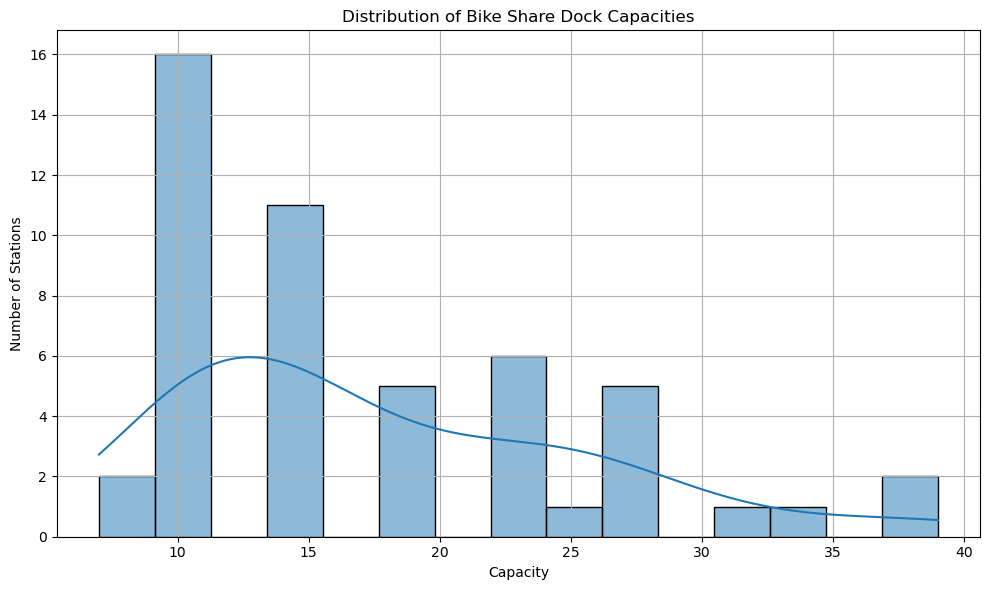

In [241]:
plt.figure(figsize=(10, 6))
sns.histplot(bike_docks_clean['capacity'], bins=15, kde=True)
plt.title('Distribution of Bike Share Dock Capacities')
plt.xlabel('Capacity')
plt.ylabel('Number of Stations')
plt.grid(True)
plt.tight_layout()
plt.show()

This histogram shows how the docking stations are distributed by their capacity (i.e., the number of bikes that can be accommodated at each station). Most stations fall within the lower capacity range of 10-15 docks, which suggests that the network is designed for small to medium demand at most locations. A few larger stations exist with capacities above 25, likely located in high demand areas such as the CBD.

The kernel density estimate (KDE) curve highlights that the majority of stations are clustered around the lower end of capacity, with fewer high-capacity stations. This uneven distribution can inform planning decisions, adding higher-capacity docks in busy areas may help balance supply and reduce pressure on smaller stations.

## Density of Transport and Mobility Options in Melbourne

### Bus Stops Density Across Melbourne

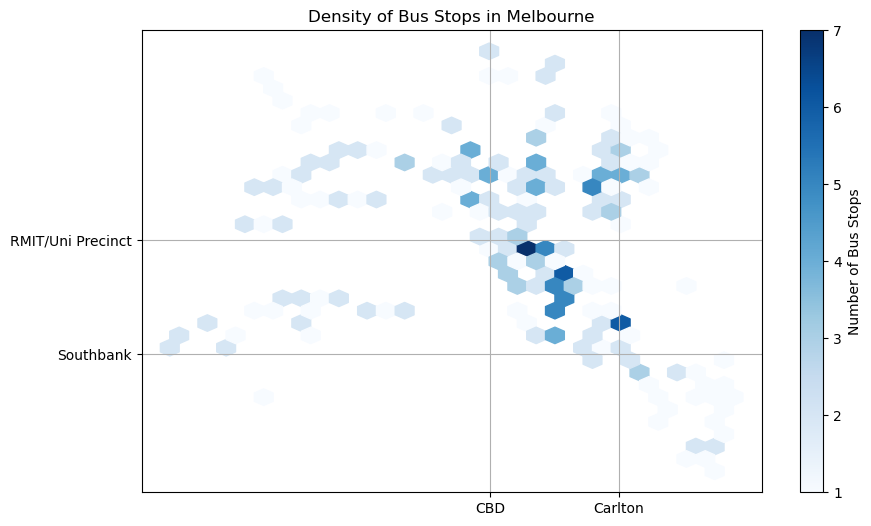

In [246]:
plt.figure(figsize=(10, 6))
plt.hexbin(bus_stops_clean['lon'], bus_stops_clean['lat'], gridsize=30, cmap='Blues', mincnt=1)
plt.colorbar(label='Number of Bus Stops')
plt.title('Density of Bus Stops in Melbourne')

plt.xticks([144.95, 144.97], ['CBD', 'Carlton'])
plt.yticks([-37.81, -37.83], ['RMIT/Uni Precinct', 'Southbank'])

plt.grid(True)
plt.show()


The bus stop density map shows strong clustering around the CBD, Southbank, and RMIT/University precinct, with darker regions indicating higher concentrations of stops. This high density means that buses are easily accessible in these central areas, making it convenient for young adults and daily commuters to move between study, work, and leisure destinations without long walks.

As we move further away from the CBD, the density of stops decreases. In outer suburbs, bus stops are more widely spaced, which often results in longer walking distances to access services and lower service frequency. This difference reflects the design of Melbourne’s bus network - greater coverage in the inner city where demand is highest, and lower coverage in suburban areas where populations are more spread out.

### Tram Stops Density Across Melbourne

In [250]:

def integer_colorbar(cb, mappable):
    counts = mappable.get_array()                 # bin counts behind the hexbin
    vmax = int(max(1, np.nanmax(counts)))         # top integer
    ticks = np.arange(1, vmax + 1)                # 1..vmax
    cb.set_ticks(ticks)
    cb.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))


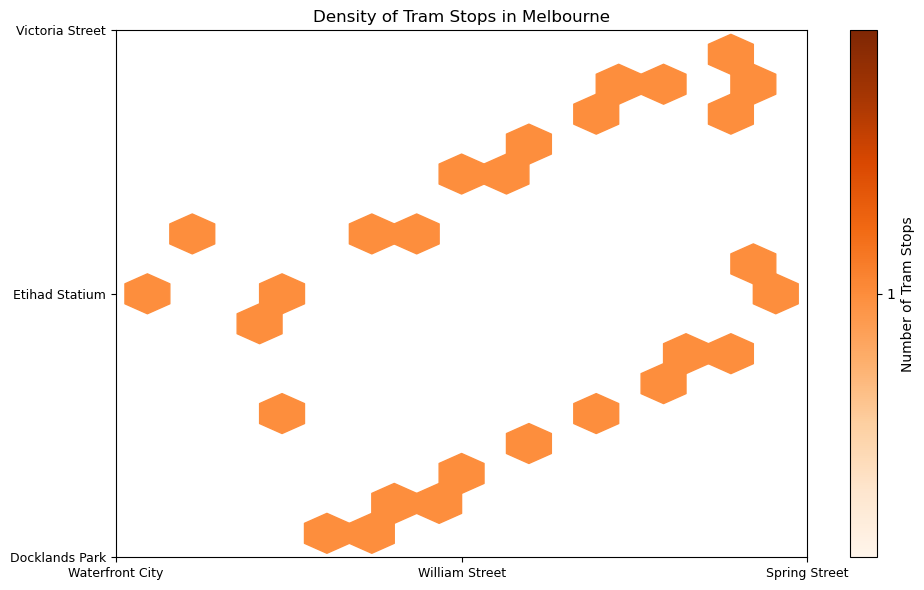

In [252]:
plt.figure(figsize=(10, 6))

# Hexbin plot of tram stops (clusters shown in orange)
hb = plt.hexbin(tram_stops_clean["lon"], tram_stops_clean["lat"],
                gridsize=14, cmap="Oranges", mincnt=1, vmin=1)

# Colourbar for number of stops
cbar = plt.colorbar(hb)
cbar.set_label("Number of Tram Stops")

# Force integer ticks on colourbar
integer_colorbar(cbar, hb)

# Get current axis
ax = plt.gca()

# Remove scientific notation from axes
ax.ticklabel_format(useOffset=False, style='plain', axis='both')
ax.xaxis.offsetText.set_visible(False)
ax.yaxis.offsetText.set_visible(False)

# Add 3 stop names on x-axis
t = tram_stops_clean[['lon','lat','name']].dropna()
idx = np.linspace(0, len(t)-1, 3, dtype=int)
px = t.sort_values('lon').iloc[idx]
ax.set_xticks(px['lon'].tolist())
ax.set_xticklabels(px['name'].tolist(), fontsize=9)

# Add 3 stop names on y-axis
py = t.sort_values('lat').iloc[idx]
ax.set_yticks(py['lat'].tolist())
ax.set_yticklabels(py['name'].tolist(), fontsize=9)

# Adjust layout and labels
plt.gcf().subplots_adjust(bottom=0.18, left=0.22)
plt.title("Density of Tram Stops in Melbourne")

# Optional dynamic labels
set_dynamic_ticks(plt.gca(), tram_stops_clean, name_col="name", n_labels=3)

plt.tight_layout()
plt.show()



The tram stop density map highlights Melbourne’s distinctive tram corridors. Stops are closely aligned along major streets such as Victoria Street, Spring Street, and William Street, reflecting the grid-based tram network that defines central Melbourne’s public transport. Darker orange hexagons indicate clusters of stops, especially near Etihad Stadium and Docklands Park, which are high-demand areas due to business, shopping, and event activities.

Compared to bus stops, tram stops are less dispersed and follow a clear linear pattern, emphasising their role in providing structured, high-capacity transport routes through the city. This density pattern shows how trams act as the backbone of Melbourne’s inner-city transport, connecting key precincts with frequent and reliable services.

## Bike Share Stations Density in Melbourne

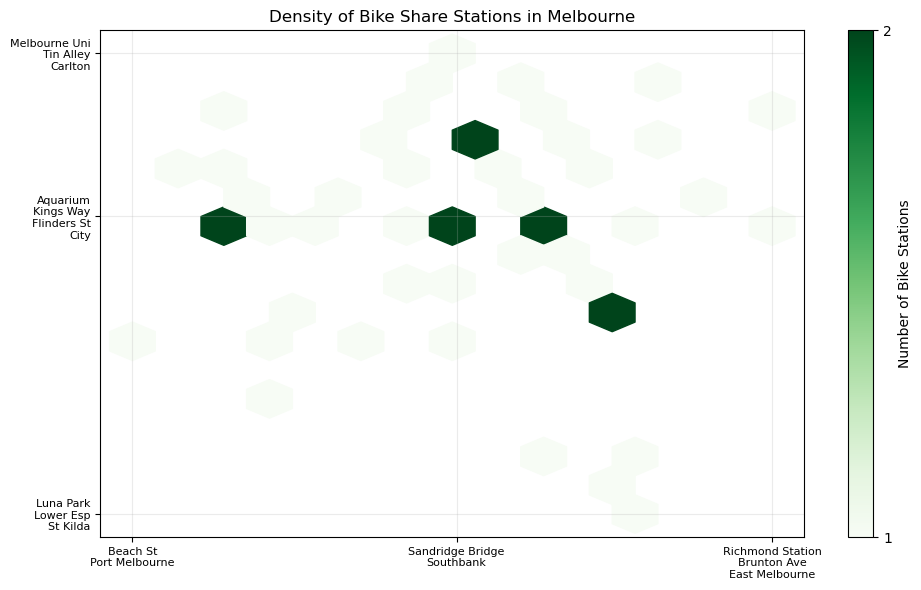

In [256]:
# Helper function to force integer ticks on colourbar
def integer_colorbar(cb, mappable):
    counts = mappable.get_array()
    vmax = int(max(1, np.nanmax(counts)))
    mappable.set_clim(1, vmax)  # lock scale to whole numbers
    cb.set_ticks(np.arange(1, vmax + 1))
    cb.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

plt.figure(figsize=(10, 6))

# Hexbin plot of bike share stations
hb = plt.hexbin(
    bike_docks_clean["lon"], bike_docks_clean["lat"],
    gridsize=14, cmap="Greens", mincnt=1, vmin=1
)

# Colourbar
cbar = plt.colorbar(hb)
cbar.set_label("Number of Bike Stations")
integer_colorbar(cbar, hb)

ax = plt.gca()

# Remove scientific notation
ax.ticklabel_format(useOffset=False, style='plain', axis='both')
ax.xaxis.offsetText.set_visible(False)
ax.yaxis.offsetText.set_visible(False)

# Prepare station names for axis ticks
b = bike_docks_clean[['lon','lat','name']].dropna()

# Add 3 names along longitude (x-axis)
idx = np.linspace(0, len(b)-1, 3, dtype=int)
px = b.sort_values('lon').iloc[idx]
ax.set_xticks(px['lon'].tolist())
ax.set_xticklabels(
    [s.replace(' / ', '\n').replace(' - ', '\n') for s in px['name'].tolist()],
    fontsize=8
)

# Add 3 names along latitude (y-axis)
py = b.sort_values('lat').iloc[idx]
ax.set_yticks(py['lat'].tolist())
ax.set_yticklabels(
    [s.replace(' / ', '\n').replace(' - ', '\n') for s in py['name'].tolist()],
    fontsize=8
)

# Adjust margins for wrapped labels
plt.gcf().subplots_adjust(bottom=0.28, left=0.32)

# Titles and labels
plt.title("Density of Bike Share Stations in Melbourne")
plt.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()


The bike share station density map shows a much sparser pattern compared to buses and trams. The stations are mainly concentrated in and around the CBD, Southbank, and Richmond areas, with only a few scattered locations extending toward Carlton and St Kilda. The darker green hexagons indicate limited but important clusters, particularly near Flinders Street, Sandridge Bridge, and Richmond Station.

This limited distribution suggests that bike share infrastructure is targeted at central, high-demand corridors rather than being evenly spread across the city. While this makes bikes accessible in the busiest zones, it also highlights the lack of coverage in outer areas, limiting the system’s effectiveness for broader last-mile connectivity.

## Train Station Density in Melbourne

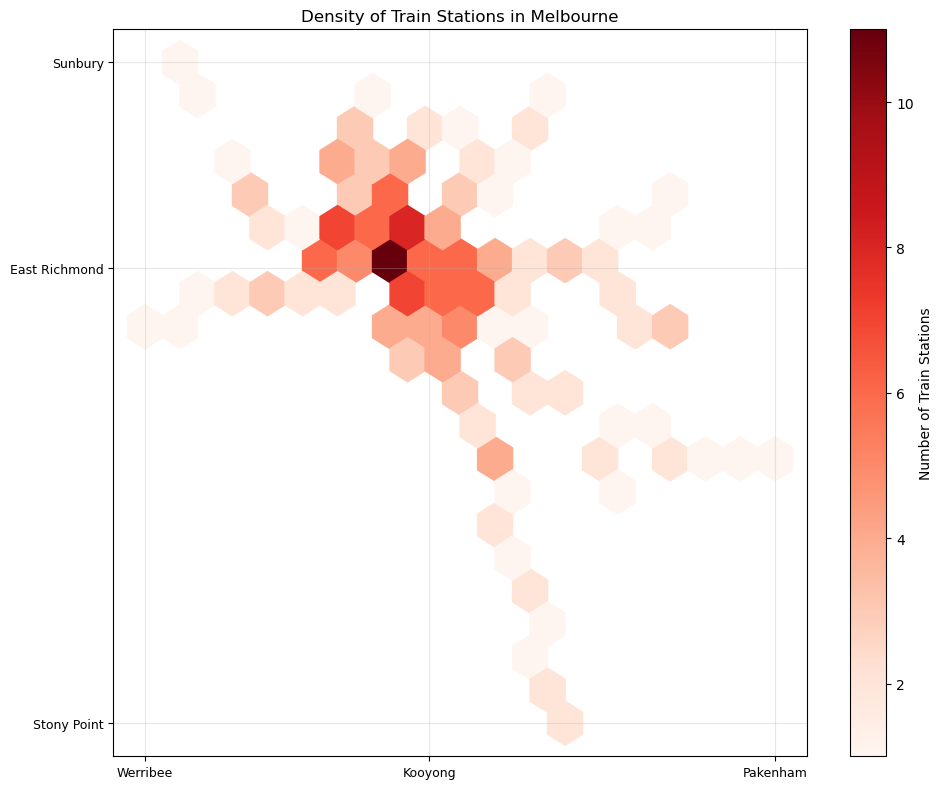

In [260]:
# Rename the column so stations have a 'name'
train_stops_clean = train_stops_clean.rename(columns={'station': 'name'})

plt.figure(figsize=(10, 8))

# Hexbin plot of train stations
hb = plt.hexbin(
    train_stops_clean['lon'], train_stops_clean['lat'],
    gridsize=18, cmap="Reds", mincnt=1, vmin=1
)

# Colourbar for station counts
cbar = plt.colorbar(hb)
cbar.set_label("Number of Train Stations")

# Remove scientific notation on axes
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain', axis='both')
ax.xaxis.offsetText.set_visible(False)
ax.yaxis.offsetText.set_visible(False)

# Pick 3 station names for x-axis (spread across longitude)
t = train_stops_clean[['lon','lat','name']].dropna()
idx = np.linspace(0, len(t)-1, 3, dtype=int)
px = t.sort_values('lon').iloc[idx]
ax.set_xticks(px['lon'].tolist())
ax.set_xticklabels(px['name'].tolist(), fontsize=9)

# Pick 3 station names for y-axis (spread across latitude)
py = t.sort_values('lat').iloc[idx]
ax.set_yticks(py['lat'].tolist())
ax.set_yticklabels(py['name'].tolist(), fontsize=9)

# Adjust layout for labels
plt.gcf().subplots_adjust(bottom=0.2, left=0.25)

# Titles and labels
plt.title("Density of Train Stations in Melbourne")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The train station density map highlights the radial structure of Melbourne’s rail network, with the highest concentration of stations in and around the CBD. Darker red clusters indicate areas such as Flinders Street Station and the surrounding city loop, which act as the main interchange hubs.

From these central points, the network extends outwards in spokes towards suburbs such as Sunbury, Werribee, Pakenham, and Stony Point, showing how the rail system is designed to connect outer suburban areas with the city centre. This pattern reflects the role of trains as the backbone of long-distance commuting in Melbourne, complementing the finer local coverage provided by buses and trams.

## Total Public Transport and Shared Mobility Infrastructure

In [264]:
#total infrastructure 
print("Total Bus Stops:", len(bus_stops_clean))
print("Total Tram Stops:", len(tram_stops_clean))
print("Total Train Stations:", len(train_stops_clean)) 
print("Total Bike Share Stations:", len(bike_docks_clean))

Total Bus Stops: 309
Total Tram Stops: 28
Total Train Stations: 219
Total Bike Share Stations: 50


The counts summarise the availability of different transport modes across Melbourne.

Bus Stops (309): The highest count among modes, indicating that buses provide the most widespread coverage. This supports accessibility at a fine-grained, local level.

Tram Stops (28): A relatively smaller number of stops, but trams run along dense, high-demand corridors in the inner city, offering frequent and reliable services.

Train Stations (219): A substantial number of stations, showing the importance of trains in connecting the broader metropolitan area to the city centre. Trains form the backbone of longer-distance commuting.

Bike Share Stations (50): These offer flexibility for short trips and first/last-mile connections. While fewer in number compared to other modes, their capacity helps fill accessibility gaps within the inner city.

Together, these figures highlight the multi-modal nature of Melbourne’s transport network, where buses provide local reach, trams and trains serve as high-capacity corridors, and bike share offers additional mobility options.

## Interactive Transport Map with Hotspot Predictions

In [268]:
# Ensure train dataset has a consistent column name for station names
if "station" in train_stops_clean.columns:
    train_stops_clean = train_stops_clean.rename(columns={"station": "name"})

# Create base map centred on Melbourne
map_with_predictions = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

# Marker clusters for each mode
bus_cluster = MarkerCluster(name="Bus Stops").add_to(map_with_predictions)
tram_cluster = MarkerCluster(name="Tram Stops").add_to(map_with_predictions)
bike_cluster = MarkerCluster(name="Bike Share Docks").add_to(map_with_predictions)
train_cluster = MarkerCluster(name="Train Stations").add_to(map_with_predictions)

# Bus stop markers
for _, row in bus_stops_clean.iterrows():
    folium.Marker(
        [row['lat'], row['lon']],
        icon=folium.Icon(color='blue', icon='bus', prefix='fa'),
        popup=row.get('name', 'Bus Stop')
    ).add_to(bus_cluster)

# Tram stop markers
for _, row in tram_stops_clean.iterrows():
    folium.Marker(
        [row['lat'], row['lon']],
        icon=folium.Icon(color='orange', icon='train', prefix='fa'),
        popup=row.get('name', 'Tram Stop')
    ).add_to(tram_cluster)

# Bike dock markers (with capacity info in popup)
for _, row in bike_docks_clean.iterrows():
    folium.Marker(
        [row['lat'], row['lon']],   # <-- fixed typo here (was 'lona')
        icon=folium.Icon(color='green', icon='bicycle', prefix='fa'),
        popup=f"{row['name']} (Capacity: {row['capacity']})"
    ).add_to(bike_cluster)

# Train station markers
for _, row in train_stops_clean.iterrows():
    folium.Marker(
        [row['lat'], row['lon']],
        icon=folium.Icon(color='red', icon='train', prefix='fa'),
        popup=row['name']
    ).add_to(train_cluster)

# Heatmap for large bike stations (capacity > 35)
hot_stations = bike_docks_clean[bike_docks_clean['capacity'] > 35]
heat_data = hot_stations[['lat', 'lon']].copy()
heat_data['intensity'] = hot_stations['capacity']

HeatMap(
    data=heat_data[['lat', 'lon', 'intensity']].values,
    name="Hot Bike Stations",
    min_opacity=0.5,
    radius=25,
    blur=18,
    max_zoom=1
).add_to(map_with_predictions)

# Add layer control (to toggle modes on/off) and save map
folium.LayerControl().add_to(map_with_predictions)
map_with_predictions.save("melbourne_transport_predictions_with_hotspots.html")

map_with_predictions


This map shows the distribution of bus stops, tram stops, bike share docks, and train stations in Melbourne. Each marker represents a transport facility, and clusters highlight where many options are close together.

Areas with dense clusters show strong connectivity and easy transfers between travel modes. In contrast, sparser areas reveal limited coverage and possible gaps in the network.

The bike dock heatmap highlights high-capacity stations, showing where cycling is well supported.

Overall, the map helps identify well-connected regions, gaps in service, and opportunities to improve transport accessibility.

## Average Nearby Stops/Stations per Mode

       within_300m  within_500m
mode                           
bike           3.2          9.1
bus            7.0         15.2
train          0.3          0.6
tram           6.9         15.8


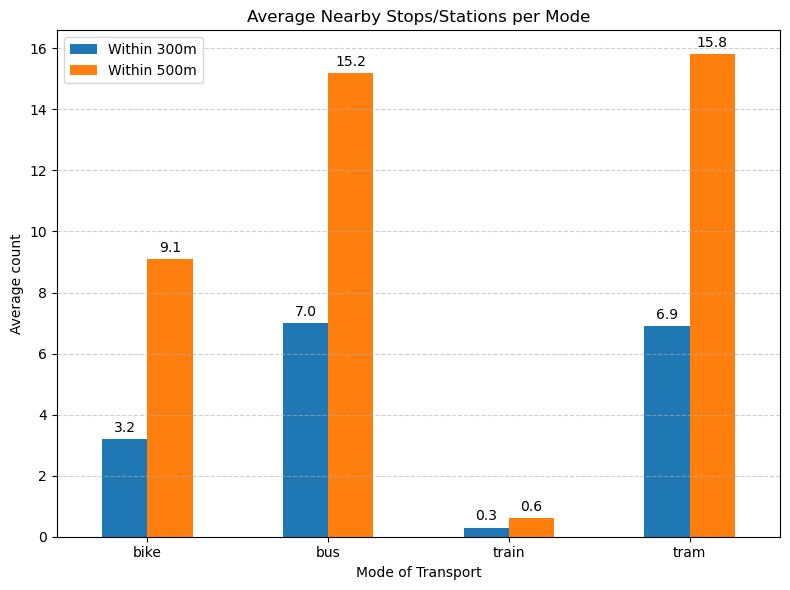

In [271]:
# Prepare a unified dataframe of all stops with a 'mode' column
def prep_mode_df():
    frames = []
    
    # Bus stops
    if 'bus_stops_clean' in globals():
        b = bus_stops_clean[['lat','lon']].copy(); b['mode'] = 'bus'; frames.append(b)
    else:
        b = bus_stops[['lat','lon']].copy(); b['mode'] = 'bus'; frames.append(b)

    # Tram stops
    if 'tram_stops_clean' in globals():
        t = tram_stops_clean[['lat','lon']].copy(); t['mode'] = 'tram'; frames.append(t)
    else:
        t = tram_stops[['lat','lon']].copy(); t['mode'] = 'tram'; frames.append(t)

    # Bike docks
    if 'bike_docks_clean' in globals():
        k = bike_docks_clean[['lat','lon']].copy(); k['mode'] = 'bike'; frames.append(k)
    else:
        k = bike_docks[['lat','lon']].copy(); k['mode'] = 'bike'; frames.append(k)

    # Train stations (NEW)
    if 'train_stops_clean' in globals():
        r = train_stops_clean[['lat','lon']].copy(); r['mode'] = 'train'; frames.append(r)
    else:
        r = train_stops[['lat','lon']].copy(); r['mode'] = 'train'; frames.append(r)

    all_df = pd.concat(frames, ignore_index=True)
    return all_df

# Build combined dataset (now includes train)
all_stops = prep_mode_df()

# Compute neighbour counts within 300m and 500m (naive O(n^2) scan)
radii = [300, 500]
results = []
for idx, row in all_stops.iterrows():
    lat1, lon1, mode1 = row['lat'], row['lon'], row['mode']
    counts = {'within_300m': 0, 'within_500m': 0}
    for jdx, row2 in all_stops.iterrows():
        if idx == jdx: 
            continue
        d = haversine_m(lat1, lon1, row2['lat'], row2['lon'])
        if d <= 300: counts['within_300m'] += 1
        if d <= 500: counts['within_500m'] += 1
    counts['mode'] = mode1
    results.append(counts)

# Aggregate by mode and keep one decimal for visibility
access_df = pd.DataFrame(results)
summary_access = (
    access_df
    .groupby('mode')[['within_300m','within_500m']]
    .mean()
    .round(1)
)
print(summary_access)

# Plot averages with labels on bars
ax = summary_access.plot(
    kind='bar',
    figsize=(8,6),
    color=['#1f77b4','#ff7f0e']   # within 300m / 500m
)
plt.title("Average Nearby Stops/Stations per Mode")
plt.ylabel("Average count")
plt.xlabel("Mode of Transport")
plt.xticks(rotation=0)
plt.legend(["Within 300m","Within 500m"])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Add numeric labels (one decimal) on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.show()


This chart compares the average number of nearby stops or stations for different transport modes (bike, bus, tram, train) within 300m and 500m.

Buses and trams show the highest accessibility, with around 7–15 stops on average nearby, making them the most convenient modes.

Bike docks are moderately available, averaging 3.2 stops within 300m and 9.1 within 500m.

Train stations are the least frequent, with less than 1 on average, reflecting their wider spacing compared to local modes.

Overall, the chart highlights how buses and trams dominate short-distance accessibility, while trains provide broader, less dense coverage.

## Distribution of Nearby Stops/Stations by Mode

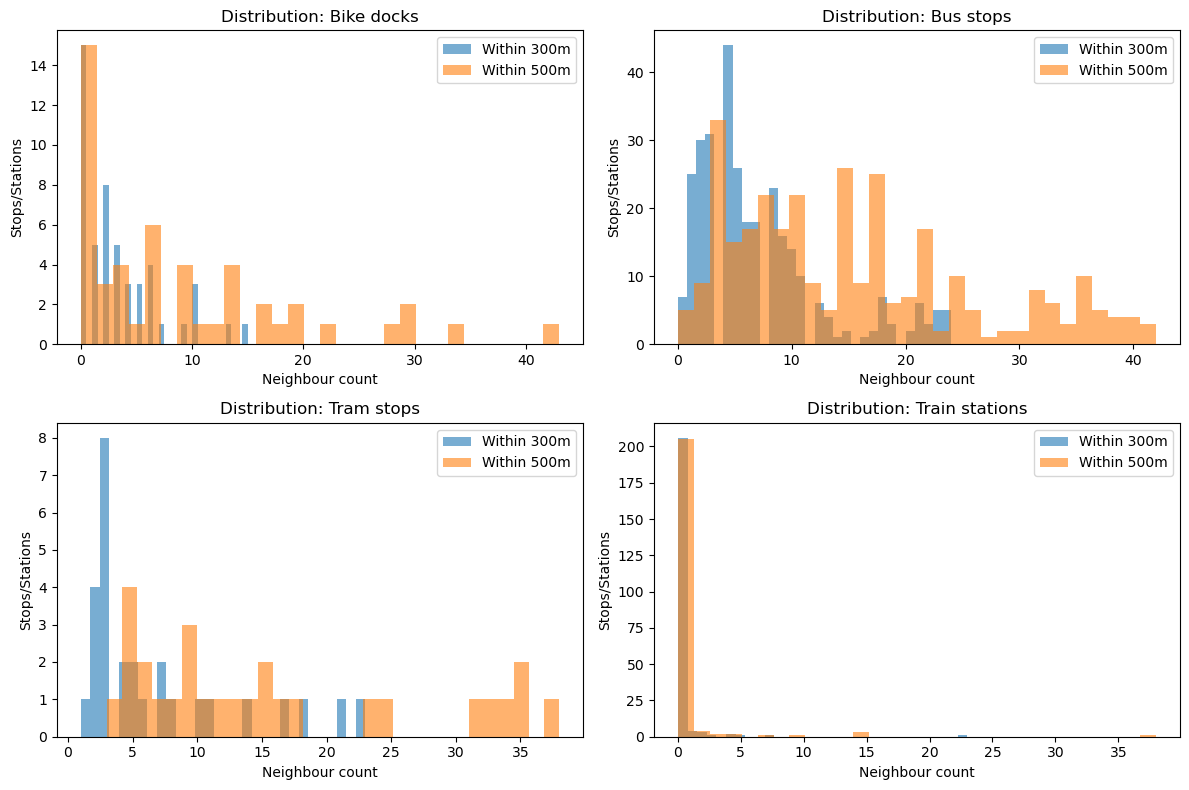

In [276]:
# Create 2x2 grid for histograms of all 4 modes
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# Modes to plot
modes = ['bike', 'bus', 'tram', 'train']
titles = {
    'bike': "Bike docks",
    'bus': "Bus stops",
    'tram': "Tram stops",
    'train': "Train stations"
}

# Plot histogram for each mode
for ax, mode in zip(axes.flat, modes):
    subset = access_df[access_df['mode'] == mode]
    
    # Histogram of neighbour counts within 300m and 500m
    ax.hist(subset['within_300m'], bins=30, alpha=0.6, label='Within 300m')
    ax.hist(subset['within_500m'], bins=30, alpha=0.6, label='Within 500m')
    
    # Titles and labels
    ax.set_title(f"Distribution: {titles[mode]}")
    ax.set_xlabel("Neighbour count")
    ax.set_ylabel("Stops/Stations")
    ax.legend()

plt.tight_layout()
plt.show()


These histograms show how the number of nearby stops or stations varies across different transport modes within 300m (blue) and 500m (orange).

Bus stops have the widest spread, with many areas offering 5–20 nearby stops, and some places reaching more than 30 within 500m, showing strong local accessibility.

Tram stops are also well distributed, with most areas having 5–15 stops within 500m, reflecting Melbourne’s dense tram network.

Bike docks are fewer but still clustered, mostly offering under 10 nearby docks, though a few areas go beyond 20 within 500m.

Train stations are the sparsest, with almost all areas having 0–2 stations nearby, confirming their wider spacing.

Overall, the plots highlight how buses and trams dominate short-distance coverage, while trains provide broader but less frequent access, and bikes serve as a supplementary mode.

## Multimodal Overlap Hotspots

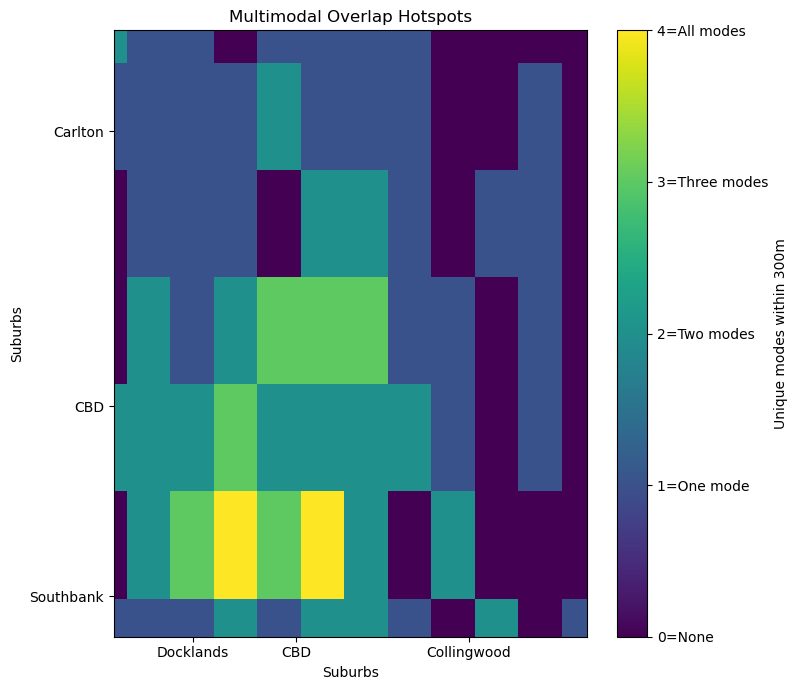

In [280]:
# Distance and grid settings
radius_m = 300
grid_n   = 150
R_earth  = 6_371_000
radius_rad = radius_m / R_earth

# Prepare all stops (bus, tram, bike, train)
all_stops = prep_mode_df().copy()
assert {'lat','lon','mode'}.issubset(all_stops.columns)

# Build a BallTree for each mode
modes = ['bus','tram','bike','train']
trees = {}
for m in modes:
    dfm = all_stops[all_stops['mode'] == m][['lat','lon']]
    if len(dfm) > 0:
        coords = np.radians(dfm[['lat','lon']].to_numpy())
        trees[m] = BallTree(coords, metric='haversine')
    else:
        trees[m] = None

# Create a lat/lon grid across Melbourne
min_lon, max_lon = all_stops['lon'].min(), all_stops['lon'].max()
min_lat, max_lat = all_stops['lat'].min(), all_stops['lat'].max()
lon_grid = np.linspace(min_lon, max_lon, grid_n)
lat_grid = np.linspace(min_lat, max_lat, grid_n)
gx, gy = np.meshgrid(lon_grid, lat_grid)
grid_points_rad = np.radians(np.c_[gy.ravel(), gx.ravel()])

# Count how many modes exist within 300m of each grid cell
present_stack = []
for m in modes:
    tree = trees[m]
    if tree is None:
        present_stack.append(np.zeros(grid_points_rad.shape[0], dtype=bool))
    else:
        counts = tree.query_radius(grid_points_rad, r=radius_rad, count_only=True)
        present_stack.append(counts > 0)
mode_richness = np.sum(np.vstack(present_stack), axis=0).reshape(grid_n, grid_n)

# Suburb reference points for axis ticks
geolocator = Nominatim(user_agent="hotspot_mapper")
tick_points = {
    "Docklands": (-37.8156, 144.9500),
    "CBD":       (-37.8136, 144.9631),
    "Southbank": (-37.8230, 144.9646),
    "Carlton":   (-37.8000, 144.9660),
    "Collingwood": (-37.8010, 144.9850)
}

# Try to resolve suburb names, fallback to keys if needed
labels = {}
for name, coords in tick_points.items():
    try:
        loc = geolocator.reverse(coords, language="en")
        suburb = loc.raw['address'].get('suburb', name)
        labels[name] = suburb
    except Exception:
        labels[name] = name

# Plot multimodal overlap heatmap
fig, ax = plt.subplots(figsize=(8,7))
im = ax.imshow(
    mode_richness,
    origin='lower',
    extent=[min_lon, max_lon, min_lat, max_lat],
    aspect='auto',
    vmin=0, vmax=len(modes),
    interpolation='nearest'
)

# Colourbar showing number of modes
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Unique modes within 300m')
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(['0=None','1=One mode','2=Two modes','3=Three modes','4=All modes'])

ax.set_title('Multimodal Overlap Hotspots')
ax.set_xlabel('Suburbs')
ax.set_ylabel('Suburbs')

# Focus on CBD area
ax.set_xlim(144.94, 145.00)
ax.set_ylim(-37.825, -37.795)

# Replace numeric ticks with suburb names
ax.xaxis.set_major_locator(FixedLocator([144.95, 144.9631, 144.985]))
ax.xaxis.set_major_formatter(FixedFormatter(['Docklands', 'CBD', 'Collingwood']))
ax.yaxis.set_major_locator(FixedLocator([-37.8230, -37.8136, -37.8000]))
ax.yaxis.set_major_formatter(FixedFormatter(['Southbank', 'CBD', 'Carlton']))

plt.tight_layout()
plt.show()


This heatmap shows how different transport modes overlap within 300m across Melbourne areas like Docklands, CBD, Carlton, Southbank, and Collingwood.

Yellow zones (value 4) mean all four modes-bus, tram, train, and bike-are available in close proximity, offering the highest connectivity.

Green areas (2-3 modes) show partial overlap, where travellers still have multiple options but not the full set.

Dark blue/purple areas (0-1 mode) highlight limited coverage, where commuters rely on a single mode or none at all.

This map highlights that CBD and Southbank have the strongest multimodal integration, while suburbs and fringe areas tend to show weaker overlap.

## Nearest Neighbour Distance Analysis

In [284]:
# Nearest neighbour function
def nearest_neighbour_same_mode(df):
    dists = []
    for i, r in df.iterrows():
        min_d = float('inf')
        for j, s in df.iterrows():
            if i == j: 
                continue
            d = haversine_m(r['lat'], r['lon'], s['lat'], s['lon'])
            if d < min_d: 
                min_d = d
        dists.append(min_d)
    return pd.Series(dists, name='nn_meters')


# Filter stops per mode
bus_stops   = all_stops[all_stops['mode'] == 'bus']
tram_stops  = all_stops[all_stops['mode'] == 'tram']
bike_stops  = all_stops[all_stops['mode'] == 'bike']
train_stops = all_stops[all_stops['mode'] == 'train']

# Counts
counts = {
    'bus':   len(bus_stops),
    'tram':  len(tram_stops),
    'bike':  len(bike_stops),
    'train': len(train_stops)
}

# Nearest neighbour distances
nn_bus   = nearest_neighbour_same_mode(bus_stops)
nn_tram  = nearest_neighbour_same_mode(tram_stops)
nn_bike  = nearest_neighbour_same_mode(bike_stops)
nn_train = nearest_neighbour_same_mode(train_stops)

# Summary table
nn_summary = pd.DataFrame({
    'mode': ['bus','tram','bike','train'],
    'count': [counts['bus'], counts['tram'], counts['bike'], counts['train']],
    'NN_mean_m': [nn_bus.mean(), nn_tram.mean(), nn_bike.mean(), nn_train.mean()],
    'NN_median_m': [nn_bus.median(), nn_tram.median(), nn_bike.median(), nn_train.median()]
}).round(2)

nn_summary


,mode,count,NN_mean_m,NN_median_m
0,bus,309,88.65,43.16
1,tram,28,218.84,226.38
2,bike,50,474.77,432.37
3,train,219,1426.75,1113.24


This table shows how close each mode of transport stop/station is to its nearest neighbour of the same type.

Bus stops are the most closely spaced, with a median gap of only ~43 m, reflecting their dense coverage across Melbourne.

Tram stops are less dense, with median spacing of ~226 m, still offering frequent access in inner suburbs.

Bike docks are spread further apart, with typical gaps of 400-500 m, consistent with their role as key hubs rather than every-corner facilities.

Train stations are the most widely spaced, with distances of over 1 km between them, reflecting the larger scale of rail infrastructure.

This analysis is useful because it highlights service density: buses and trams are designed for short-distance urban mobility, while trains serve longer commutes. Bike-share docks sit between these extremes, supporting first/last-mile travel.